# Stock Analysis: return-risk performance vs S&P500 index

Find stocks that outperform the SP500 index, year after year, as well based on return (higher return) as on risk (lower risk)
## Datasets

We use two datasets:

### **from Kaggle: S&P 500 stock data**

https://www.kaggle.com/camnugent/sandp500 file: all_stocks_5yrs.csv

This dataset contains all stocks in the S&P 500 index, and their historical prices for the past 5 years

### **from yahoo: S&P 500 index historical prices**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime as dt
from math import sqrt

## Explore the Kaggle dataset all_stocks_5yrs.csv 
How many observations and features do we have

In [2]:
data = pd.read_csv('./all_stocks_5yr.csv')

In [3]:
data.shape

(606801, 7)

In [4]:
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


For each trading day we have the ticker symbol (Name) and the price at opening (Open), closing (Close), highest (High) and lowest (Low) of the day and the number of stocks traded (Volume).

What are the types of the columns?

In [5]:
data.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
Name       object
dtype: object

We will only use the Date, Close and Name features for this exercise.

Convert the Date column to datetime

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

What is the time period over which we have date?

In [7]:
data.Date.min(), data.Date.max()

(Timestamp('2012-08-13 00:00:00'), Timestamp('2017-08-11 00:00:00'))

Split the total period in 5 periods of approx 1 year each

In [8]:
periods = np.array_split(data.Date.unique(), 5)

In [9]:
for yr in range(5):
    print(periods[yr].min(), periods[yr].max())

2012-08-13T00:00:00.000000000 2013-08-14T00:00:00.000000000
2013-08-15T00:00:00.000000000 2014-08-14T00:00:00.000000000
2014-08-15T00:00:00.000000000 2015-08-14T00:00:00.000000000
2015-08-17T00:00:00.000000000 2016-08-12T00:00:00.000000000
2016-08-15T00:00:00.000000000 2017-08-11T00:00:00.000000000


Create a multi-index for better retrieval later

In [10]:
data.set_index(['Name', 'Date'], inplace=True)
data.head()

Open   High    Low  Close     Volume
Name Date                                             
MMM  2012-08-13  92.29  92.59  91.74  92.40  2075391.0
     2012-08-14  92.36  92.50  92.01  92.30  1843476.0
     2012-08-15  92.00  92.74  91.94  92.54  1983395.0
     2012-08-16  92.75  93.87  92.21  93.74  3395145.0
     2012-08-17  93.93  94.30  93.59  94.24  3069513.0

Are there any null values?

In [11]:
pd.isnull(data['Close']).any()

False

How much data points do we have?

The list of stock symbols:

In [12]:
symbols = list(data.index.levels[0])
symbols[:10]

['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI']

In [13]:
symbols[-10:]

['XL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']

How many symbols do we have?

In [14]:
len(symbols)

503

Facebook (ticker symbol 'FB') is one of these superstar companies of the past 5 year.
Plot the price evolution of facebook

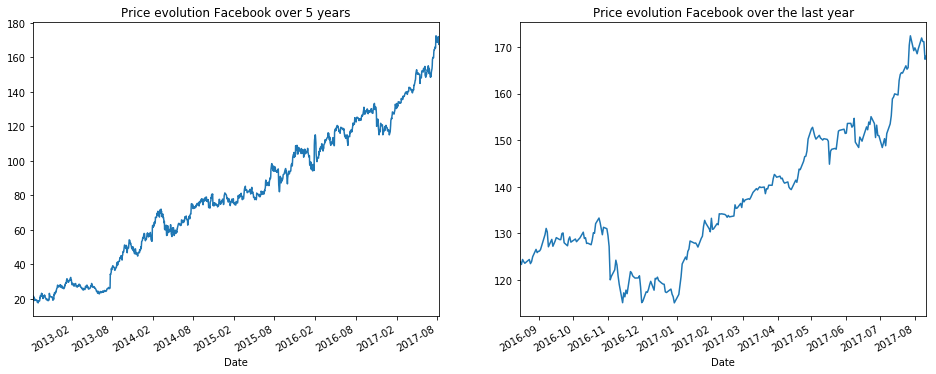

In [15]:
plt.gcf().set_size_inches(16, 6)
plt.subplot(121)
data.loc['FB'].Close.plot()
plt.title('Price evolution Facebook over 5 years')
plt.subplot(122)
data.loc['FB'].loc[periods[4]].Close.plot()
plt.title('Price evolution Facebook over the last year')
plt.show()

## Create and explore the dataset with historical prices for the S&P 500 index, retrieved from yahoo finance

We can get similar data as those from Kaggle, via the webservice of Yahoo finance
The pandas_datareader (https://github.com/pydata/pandas-datareader) module allows easy downloading of stock data in a pandas DataFrame

Let's dowload the S&P 500 index (ticker='^GSPC') historical data.

In [16]:
import pandas_datareader as pdr
sp500_index = pdr.get_data_yahoo('^GSPC')
sp500_index.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,1126.599976,1127.640015,1114.810059,1115.099976,1115.099976,2076990000
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000


What is the date range of the data?

In [17]:
sp500_index.index.min(), sp500_index.index.max()

(Timestamp('2009-12-31 00:00:00'), Timestamp('2017-09-18 00:00:00'))

Align the date range with the data from Kaggle

In [18]:
sp500_index = sp500_index.loc[data.index.min()[1]:data.index.max()[1],:]

join the sp500 index data with the kaggle data 

In [19]:
sp500_index['Name'] = '^GSPC'
sp500_index['Date'] = sp500_index.index
sp500_index.set_index(['Name', 'Date'], inplace=True)
data = pd.concat([data, sp500_index])

In [20]:
symbols.append('^GSPC')
symbols[-10:]

['XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS', '^GSPC']

Facebook is one of those stocks that outperformed the index.
Plot the historical return of 'FB' (Facebook) against the S&P 500 index

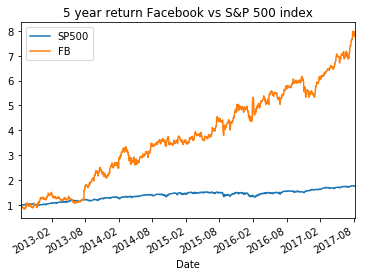

In [21]:
sp500_return = data.loc['^GSPC'].Close / data.loc['^GSPC'].Close[0]
fb_return = data.loc['FB'].Close /  data.loc['FB'].Close[0]

sp500_return.plot(label='SP500')
fb_return.plot(label='FB')
plt.legend()
plt.title('5 year return Facebook vs S&P 500 index')
plt.show()

## Research question

1. Which stocks performed better last year than the index, with higher return and lower risk
2. Which performed better than the index year after year

## Research method

1. define function to calculate return / risk ratio for a particular year
1. calculate return / risk ratio for every year for all tickers, including S&P 500 index (ticker: ^GSPC)
1. visualise the results
1. calculate the relative performance for each ticker vs the index  
1. rank tickers on return / risk ratio, show top 20 
1. filter tickers, selects the ones with better performance than SP500 index
1. which stocks performed better than the SP500 index more than twice over the past 5 year

### Define function to calculate return / risk ratio for a particular year

For the return we perform a linear regressions over the time series period. With the linear trendline we avoid daily fluctuations, and get a general idea of the return.
We define the return as the ratio of the price at the end date over the price of the start date (regression values).

We define the risk as the standard deviation of the real prices vs the trendline, relative over the start price (regression value).

For the return-risk-ratio we divide the return by the risk. For alternative return-risk-ratio definition see for example the Sharpe ratio

In [22]:
def return_risk_ratio(ticker, start, end):
    """Return a tuple: (relative return over period, risk over the period, return/risk)"""
    # select the data for the ticker and time period
    data_masked = data.loc[ticker].loc[start:end]
    x = np.arange(data_masked.Close.size)
    y = np.array(data_masked.Close)

    # Fit a degree 1 regression line
    fit = np.polyfit(x, y, 1)
    fit_fn = np.poly1d(fit)
    y_regression = fit_fn(x)
    
    # Calculate Root Mean Square Error = beta = risk
    RMSE = sqrt(mean_squared_error(y_true = y, y_pred = y_regression))
    slope = fit_fn.coeffs[0]
    y0_regression = fit_fn(x[0])
    return_percent = slope / y0_regression * x.size * 100 # return in percent 
    RMSE_percent = RMSE / y0_regression * 100
    return (return_percent, RMSE_percent , return_percent / RMSE_percent)


### Calculate return / risk ratio for latest year for all tickers, including S&P 500 index (ticker: SPY)

Get the start and end dates of the last year of data

In [23]:
start_date_iso = dt.date.isoformat(pd.Timestamp(periods[4].min()))
end_date_iso = dt.date.isoformat(pd.Timestamp(periods[4].max()))

print(start_date_iso, end_date_iso)

2016-08-15 2017-08-11


Check return / risk ratio for Facebook

In [24]:
print(list(return_risk_ratio('FB', start_date_iso, end_date_iso)))
# print(return_risk_ratio('^GSPC', start_date, end_date))

[37.989594789121853, 6.089189846098324, 6.2388586576035001]


Calculate return / risk ratios for all S&P 500 symbols and store the results in a Dataframe

In [25]:
# create an empty Dataframe
rrr_index = symbols
rrr_columns = ['Period', 'Symbol', 'Return', 'Risk', 'ReturnRiskRatio', 'RiskReturnToIndex']
rrr = pd.DataFrame(columns=rrr_columns)

In [26]:
# Fill the Dataframe with the return risk ratios
n = 0
for i, p in enumerate(periods):
    start_date_iso = dt.date.isoformat(pd.Timestamp(p.min()))
    end_date_iso = dt.date.isoformat(pd.Timestamp(p.max()))
    for s in symbols: 
        #print(i, s, start_date_iso, end_date_iso)
        if data.loc[s].loc[start_date_iso:end_date_iso].size > 0: # data available for that period
            ret, risk, ratio = return_risk_ratio(s, start_date_iso, end_date_iso)
            rrr.loc[n] = [i, s, ret, risk, ratio, np.NaN]
        n = n + 1
rrr.head()    

,Period,Symbol,Return,Risk,ReturnRiskRatio,RiskReturnToIndex
0,0.0,A,25.046657,4.698386,5.330907,NaN
2,0.0,AAP,23.978840,4.168783,5.752000,NaN
3,0.0,AAPL,-42.871417,6.619575,-6.476460,NaN
4,0.0,ABBV,35.919687,5.298701,6.778961,NaN
5,0.0,ABC,66.661877,3.606360,18.484532,NaN


Set a multi index for easier data retrieval

In [27]:
rrr.set_index(['Period', 'Symbol'], inplace=True)
rrr.head()

Return      Risk  ReturnRiskRatio  RiskReturnToIndex
Period Symbol                                                         
0.0    A       25.046657  4.698386         5.330907                NaN
       AAP     23.978840  4.168783         5.752000                NaN
       AAPL   -42.871417  6.619575        -6.476460                NaN
       ABBV    35.919687  5.298701         6.778961                NaN
       ABC     66.661877  3.606360        18.484532                NaN

Check the data for Facebook and the SP500 index

In [28]:
rrr.loc[0].loc['FB']

Return               44.340001
Risk                 16.493497
ReturnRiskRatio       2.688332
RiskReturnToIndex          NaN
Name: FB, dtype: float64

In [29]:
rrr.loc[0].loc['^GSPC']

Return               23.459875
Risk                  2.537375
ReturnRiskRatio       9.245726
RiskReturnToIndex          NaN
Name: ^GSPC, dtype: float64

### Visualise the results

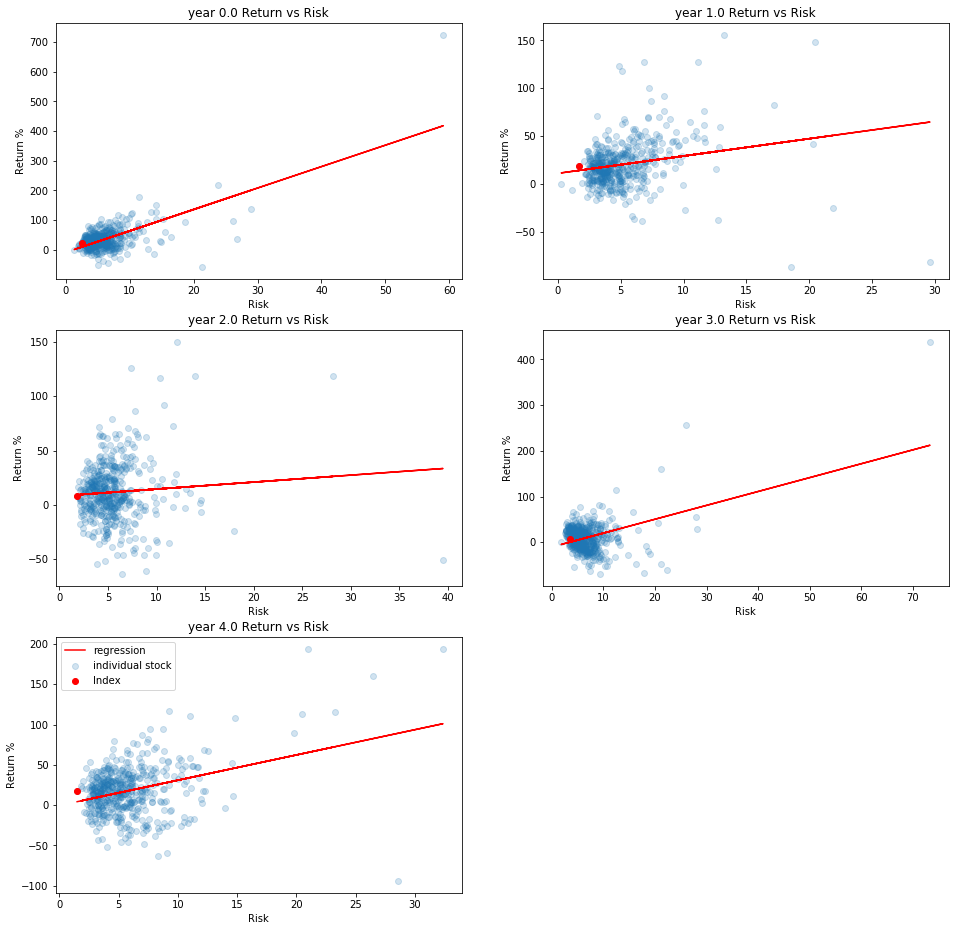

In [30]:
plt.gcf().set_size_inches(16, 16)
subplot = 320
for y in rrr.index.levels[0]:
    subplot += 1
    plt.subplot(subplot)
    rrry = rrr.loc[y]
    plt.scatter(rrry.Risk, rrry.Return, alpha=.2, label='individual stock')
    plt.scatter(rrry.loc['^GSPC'].Risk, rrry.loc['^GSPC'].Return, c='r', label='Index')
    fit = np.polyfit(rrry.Risk, rrry.Return, deg=1)
    plt.plot(rrry.Risk, fit[0] * rrry.Risk + fit[1], color='red', label='regression')
    plt.xlabel('Risk')
    plt.ylabel('Return %')
    title = "year {} Return vs Risk".format(y)
    plt.title(title)
plt.legend()
plt.show()

### Calculate the relative performance for each ticker vs the index for every year

In [31]:
for y in rrr.index.levels[0]:
    for s in symbols:
        if s in rrr.loc[y].index: # data available for that period
            rrr.loc[y].loc[s].RiskReturnToIndex = \
                rrr.loc[y].loc[s].ReturnRiskRatio / rrr.loc[y].loc['^GSPC'].ReturnRiskRatio
rrr.head()
#rrr.nlargest(20, 'RiskReturnToIndex')

Return      Risk  ReturnRiskRatio  RiskReturnToIndex
Period Symbol                                                         
0.0    A       25.046657  4.698386         5.330907           0.576581
       AAP     23.978840  4.168783         5.752000           0.622125
       AAPL   -42.871417  6.619575        -6.476460          -0.700482
       ABBV    35.919687  5.298701         6.778961           0.733199
       ABC     66.661877  3.606360        18.484532           1.999251

### Rank tickers on relative return / risk ratio, show top 20

In [32]:
rrr.nlargest(10, 'RiskReturnToIndex')

Return      Risk  ReturnRiskRatio  RiskReturnToIndex
Period Symbol                                                         
3.0    AWK     65.496224  4.050542        16.169742           7.074899
       NI      57.970661  3.938398        14.719350           6.440295
       SCG     44.290073  3.019703        14.667028           6.417402
       DLR     78.305088  5.540105        14.134224           6.184280
       REG     39.028448  2.765380        14.113231           6.175094
       O       61.370112  4.699451        13.058995           5.713825
       LNT     49.119546  4.020575        12.217044           5.345438
       T       37.097092  3.173536        11.689515           5.114623
       NOC     35.049540  3.108853        11.274107           4.932866
       JNJ     33.984054  3.187696        10.661009           4.664611

### Filter tickers, selects the ones with better performance than SP500 index

In [33]:
best_performers = rrr[rrr.RiskReturnToIndex > 1]
len(best_performers)

555

So only about 20% of the stocks performs better than the SP500 index!

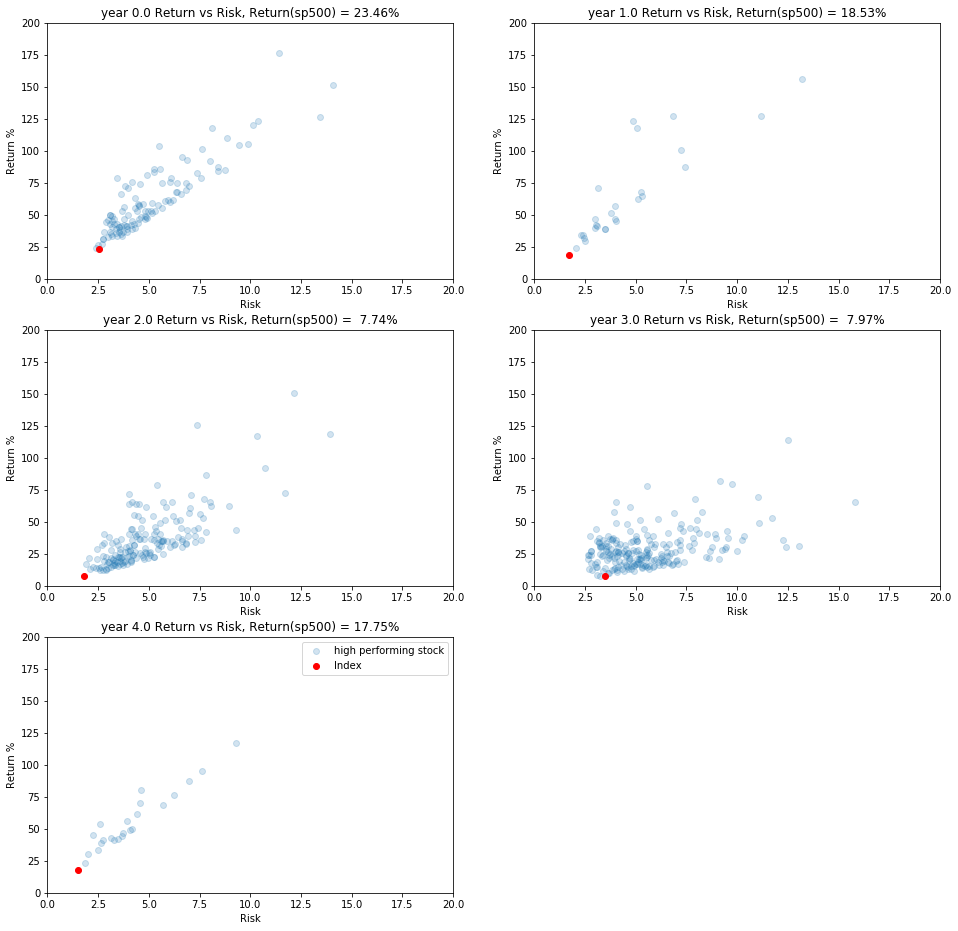

In [34]:
plt.gcf().set_size_inches(16, 16)
subplot = 320
for y in rrr.index.levels[0]:
    subplot += 1
    ax = plt.subplot(subplot)
    ax.set_xlim([0, 20]) # fix risk and return scale to for all subplots
    ax.set_ylim([0, 200])
    rrry = rrr.loc[y]
    best_performersy = best_performers.loc[y]
    plt.scatter(best_performersy.Risk, best_performersy.Return, alpha=.2, label='high performing stock')
    plt.scatter(rrry.loc['^GSPC'].Risk, rrry.loc['^GSPC'].Return, c='r', label='Index')
    plt.xlabel('Risk')
    plt.ylabel('Return %')
    title = "year {} Return vs Risk, Return(sp500) = {:5.2f}%".format(y, rrry.loc['^GSPC'].Return)
    plt.title(title)
plt.legend()
plt.show()

### Which stocks outperformed the SP500 index more than twice

In [35]:
best_stocks = best_performers.index.get_level_values(1)
from collections import Counter
d = Counter(best_stocks)
d = {k: v for k, v in d.items() if v > 2}
print(len(d))
d.keys()

30


dict_keys(['ADBE', 'ALL', 'AON', 'AOS', 'APH', 'AVY', 'BDX', 'BSX', 'CAG', 'CVS', 'EFX', 'EXR', 'FISV', 'GIS', 'HD', 'HON', 'HSIC', 'LRCX', 'MA', 'MMC', 'NYSE:NWL', 'ORLY', 'SRE', 'TMO', 'VRSK', 'WAT', 'DPS', 'DGX', 'PGR', 'UNH'])

### Which stocks where the best performers of the last year

In [36]:
best_performers.loc[4]
#rrr.loc[4].nlargest(10, 'RiskReturnToIndex')

,Return,Risk,ReturnRiskRatio,RiskReturnToIndex
Symbol,,,,
ALL,41.491887,2.756820,15.050634,1.268898
ANTM,69.829951,4.550787,15.344588,1.293681
APH,23.637324,1.835468,12.878093,1.085734
BA,76.549269,6.240271,12.266978,1.034212
CBOE,48.774473,4.095198,11.910164,1.004129
CCL,53.417659,2.614428,20.431870,1.722583
DE,61.357344,4.425262,13.865247,1.168960
DGX,41.419440,3.295160,12.569780,1.059741
FMC,87.247589,6.969487,12.518509,1.055418


In [37]:
bestInYear = list(rrr.loc[4].nlargest(20, 'RiskReturnToIndex').index)
bestInYear

['CCL',
 'RE',
 'RCL',
 'ANTM',
 'MSFT',
 'ALL',
 'XL',
 'PGR',
 'DE',
 'UNH',
 'MA',
 'APH',
 'MU',
 'DGX',
 'PCLN',
 'FMC',
 'LRCX',
 'BA',
 'ROK',
 'ROP']

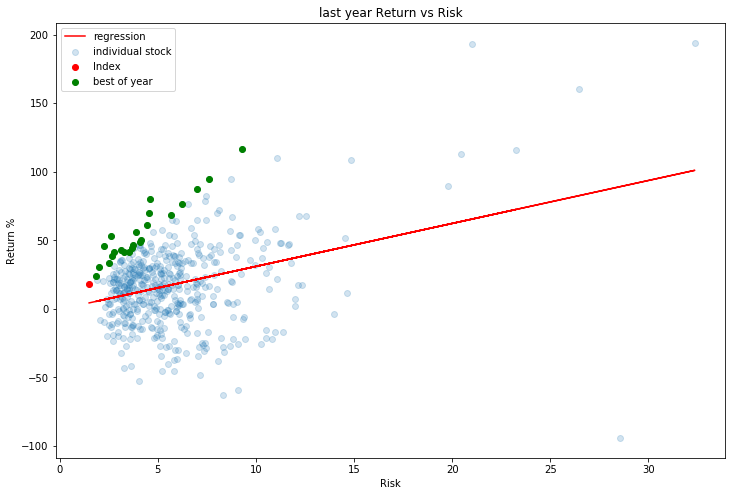

In [38]:
plt.gcf().set_size_inches(12, 8)

rrry = rrr.loc[4]
best4 = best_performers.loc[4]
plt.scatter(rrry.Risk, rrry.Return, alpha=.2, label='individual stock')
plt.scatter(rrry.loc['^GSPC'].Risk, rrry.loc['^GSPC'].Return, c='r', label='Index')
fit = np.polyfit(rrry.Risk, rrry.Return, deg=1)
plt.plot(rrry.Risk, fit[0] * rrry.Risk + fit[1], color='red', label='regression')
plt.scatter(best4.Risk, best4.Return, color='green', label='best of year')
plt.xlabel('Risk')
plt.ylabel('Return %')
title = "last year Return vs Risk".format(y)
plt.title(title)
plt.legend()
plt.show()

## Findings

* There is a positive correlation between risk and return for the obeserved data
* On average 20% of the stocks perform better than the SP500 index
* Only in year 3 of the past 5 years there are stocks which performed better than the SP500 index and with less risks, other years all stocks with higher returns also had higher risks
* Ony 30 stocks performed better than the SP500 index for more than 2 years in the past 5 years

## Limitations

* Survival bias: dataset only has historical data from the **current** S&P 500 index companies. The composition of the index changes. Over the past 5 years new companies entered the index and others were removed.
* Only S&P 500 index stocks, biased to big US companies
* We are using data of the past 5 year, a period with continuous rise of stock prices. This might influence stocks that are well performing in a bullish market. These same stocks might not perform so well in a bearish market

## Future work

* One year as investment horizon was used in this exercise. Others investment horizons can be investigated from 1 month to 2 years (possible additional data needed, upto 10 years is avaible from  yahoo, for longer investing horizons)
* Other asset classes can be investigated like bonds and commodities
* Fundamental data can be included in the model (eg sales, revenues, R&D investments, ...)
* Stocks from other than the US market can be investigated, eg Europe, developing countries
* Rolling values of return and risk can be calculated and studied for each ticker, and be compared with the index

## Final Words

 **There is no assurance that past performance is an accurate predictor of the future!**